# Resource System Ordering Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import csv
import glob
import os

## Experiment Config

In [2]:
def create_folder(folder):
    if not os.path.exists(f'figs/results/{folder}'):
        os.mkdir(f'figs/results/{folder}')  
        print("Directory '% s' created" % folder)

In [400]:
# Parameters configuration
task = 'fullrank'
metric = 'ndcg_cut_100' # 'map' or 'ndcg_cut_1000'

# create plots folder
# create_folder(folder=metric)

# This snipp code should be updated later.
if '_' in metric:
    cut_off = metric.split('_')[2] # '1000'
    plot_metric = metric.split('_')[0].upper()
    plot_metric = plot_metric + '@' + cut_off
else:
    cut_off = ''
    # plot_metric = metric.upper()
    plot_metric = metric

print(plot_metric)

NDCG@100


In [401]:
# version = 'final'
result_format = 'ndcgeval' # 'treceval' or 'ndcgeval'
# File path
metadata_file = 'metadata/metadata'
# year = "DL-20"
year = "2022"
dl_year = "dl"+year

In [402]:
# TREC DL Past Years
nist_qrel_file = f"TREC-DLs-files/TREC-DL-{year}/qrels-pass.txt"

full_nist_result_file = f'final-results/all.pass.{dl_year}.{result_format}'
partial_resource_result_file = f'final-results/all.pass.{dl_year}.SynDL.partial.{result_format}'
full_resource_result_file = f'final-results/all.pass.{dl_year}.SynDL.full.{result_format}'

## Loading metadata
Loading the metadata file to create a dictionary of runid to subtask, loading the metadata_models file to have the pipeline structure, adding the subtask info to metadata models dataframe

In [403]:
runid_to_subtasks = dict()
with open(metadata_file, 'rt', encoding = 'utf8') as f:
    reader = csv.reader(f, delimiter = ':')
    for [runid, group, _, _, _, _, maintask, _, subtask, _, _, _, _, model, _, _, _, _] in reader:
        runid_to_subtasks[runid] = subtask.split('-')[0]

In [404]:
# loading metadeta infomrmaiton for runs, we have the type of pipeline as a metadata here
metadata_models_df = pd.read_csv('metadata/metadata_models.csv', sep="\t")
metadata_models_df.head()

,run_id,LLM,pipeline
0,colbertv2,-,Colbert-v2 and using pre-trained checkpoint an...
1,cip_run_7,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
2,cip_run_1,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
3,cip_run_2,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
4,cip_run_3,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...


In [405]:
metadata_models_df['subtask'] = metadata_models_df['run_id'].map(runid_to_subtasks)
metadata_models_df.head(3)

,run_id,LLM,pipeline,subtask
0,colbertv2,-,Colbert-v2 and using pre-trained checkpoint an...,fullrank
1,cip_run_7,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
2,cip_run_1,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank


## Loading System Performance based on NIST Qrel

In [406]:
nist_qrels = pd.read_csv(nist_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

queries_judged = set(nist_qrels['qid'])

real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

print('queries_judged', len(queries_judged))
print('real_queries_judged', len(real_queries_judged))
print('t5_queries_judged', len(t5_queries_judged))
print('gpt4_queries_judged', len(gpt4_queries_judged))

queries_judged 76
real_queries_judged 76
t5_queries_judged 0
gpt4_queries_judged 0


In [407]:
print(len(nist_qrels['rel']))
print(len([x for x in nist_qrels['rel'] if x == 0]))
print(len([x for x in nist_qrels['rel'] if x == 1]))
print(len([x for x in nist_qrels['rel'] if x == 2]))
print(len([x for x in nist_qrels['rel'] if x == 3]))

386416
286459
52218
46080
1659


In [408]:
# loading qrels for different DL years
dl23_qrels = pd.read_csv("TREC-DLs-files/TREC-DL-2023/qrels-pass.txt", sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
dl22_qrels = pd.read_csv("TREC-DLs-files/TREC-DL-2022/qrels-pass.txt", sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
dl21_qrels = pd.read_csv("TREC-DLs-files/TREC-DL-2021/qrels-pass.txt", sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
dl20_qrels = pd.read_csv("TREC-DLs-files/TREC-DL-2020/qrels-pass.txt", sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
dl19_qrels = pd.read_csv("TREC-DLs-files/TREC-DL-2019/qrels-pass.txt", sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

### Loading runs on NIST qrels 

In [409]:
# Loading results on NIST qrel for specific year of DL
nist_labels_result = pd.read_csv(full_nist_result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
nist_labels_result = nist_labels_result[nist_labels_result['qid'] != 'all']
nist_labels_result['qid'] = nist_labels_result['qid'].astype(int)
nist_labels_result = nist_labels_result[(nist_labels_result['metric'] == metric)]
nist_labels_result['score'] = nist_labels_result['score'].astype('float64')

track_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric)].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
track_queries_nist_labels = track_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_track_nist = dict(zip(track_queries_nist_labels['run_id'], track_queries_nist_labels[metric]))

In [410]:
nist_labels_result

,run_id,metric,qid,score
6,srchvrs_p_bm25f,ndcg_cut_100,2000511,0.3352
16,srchvrs_p_bm25f,ndcg_cut_100,2000719,0.2325
26,srchvrs_p_bm25f,ndcg_cut_100,2001532,0.2562
36,srchvrs_p_bm25f,ndcg_cut_100,2001908,0.1986
46,srchvrs_p_bm25f,ndcg_cut_100,2001975,0.2020
...,...,...,...,...
76946,pass3,ndcg_cut_100,2055480,0.7295
76956,pass3,ndcg_cut_100,2055634,0.7238
76966,pass3,ndcg_cut_100,2055795,0.5634
76976,pass3,ndcg_cut_100,2056158,0.6018


In [411]:
# removing the runs that are for reranking task (4 runs for reranking) -> 39 runs will be remain
included_runids = metadata_models_df[metadata_models_df['subtask'] == task]['run_id']
print(len(set(included_runids)))

# We have {'D_bm25_splades', 'D_naverloo-frgpt4', 'D_naverloo_bm25_RR', 'D_naverloo_bm_splade_RR', 'colbertv2'}
# runs that have not submitted their results. So, we have 40 run_ids in metadata file in total, the rerank ones (4 runs) 
# are rmeoved from the list using the above command. Then, 36 runs we have, in whiche 5 submissions are have not submitteed their reuslt
# so we will have 31 submissions in total.

# nist_labels_result = nist_labels_result[nist_labels_result['run_id'].isin(included_runids)]
# print(len(set(nist_labels_result['run_id'])))

nist_labels_result = nist_labels_result[nist_labels_result['qid'] != 'all']
nist_labels_result['qid'] = nist_labels_result['qid'].astype(int)
nist_labels_result = nist_labels_result[(nist_labels_result['metric'] == metric)]
nist_labels_result['score'] = nist_labels_result['score'].astype('float64')

36


In [412]:
track_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric) & (nist_labels_result['qid'].isin(queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
track_queries_nist_labels = track_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_track_nist = dict(zip(track_queries_nist_labels['run_id'], track_queries_nist_labels[metric]))

generated_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric) & ((nist_labels_result['qid'].isin(t5_queries_judged)) | ((nist_labels_result['qid'].isin(gpt4_queries_judged)))) ].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
generated_queries_nist_labels = generated_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_generated_nist = dict(zip(generated_queries_nist_labels['run_id'], generated_queries_nist_labels[metric]))

real_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric) & (nist_labels_result['qid'].isin(real_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
real_queries_nist_labels = real_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_real_nist = dict(zip(real_queries_nist_labels['run_id'], real_queries_nist_labels[metric]))

t5_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric) & (nist_labels_result['qid'].isin(t5_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
t5_queries_nist_labels = t5_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_t5_nist = dict(zip(t5_queries_nist_labels['run_id'], t5_queries_nist_labels[metric]))

gpt4_queries_nist_labels = nist_labels_result[(nist_labels_result['metric'] == metric) & (nist_labels_result['qid'].isin(gpt4_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
gpt4_queries_nist_labels = gpt4_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_gpt4_nist = dict(zip(gpt4_queries_nist_labels['run_id'], gpt4_queries_nist_labels[metric]))

### Loading runs results on Resource qrels 

In [413]:
gpt4_labels_result = pd.read_csv(full_resource_result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
gpt4_labels_result.head()

gpt4_labels_result = gpt4_labels_result[gpt4_labels_result['qid'] != 'all']
gpt4_labels_result['qid'] = gpt4_labels_result['qid'].astype(int)
gpt4_labels_result = gpt4_labels_result[(gpt4_labels_result['metric'] == metric)]
gpt4_labels_result['score'] = gpt4_labels_result['score'].astype('float64')

track_queries_gpt4_labels = gpt4_labels_result[(gpt4_labels_result['metric'] == metric)].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
track_queries_gpt4_labels = track_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_track_gpt4 = dict(zip(track_queries_gpt4_labels['run_id'], track_queries_gpt4_labels[metric]))

### Loading Configs

In [414]:
# loading the metadata and assigning LLM tag based on the pipeline of each run
run_to_model = {}
# red: gpt, yellow: t5, orange: gpt+t5, and blue: everything else
for eachline in metadata_models_df.itertuples(index=True):
    # if we have both T5 and GPT version in the pipeline
    if 'T5' in eachline.LLM and 'GPT' in eachline.LLM:
        run_to_model[eachline.run_id] = 'GPT+T5'
    elif 'GPT' in eachline.LLM:
        run_to_model[eachline.run_id] = 'GPT'
    elif 'T5' in eachline.LLM:
        run_to_model[eachline.run_id] = 'T5'
    else:
        run_to_model[eachline.run_id] = 'Others'

In [415]:
def get_merged_df(dict_1, dict_2):

    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(list(dict_1.items()), columns=['Key', 'Value1'])
    df2 = pd.DataFrame(list(dict_2.items()), columns=['Key', 'Value2'])

    # Merge the DataFrames based on the 'Key' column
    merged_df = pd.merge(df1, df2, on='Key', how='outer')

    return merged_df

In [416]:
model_to_color = {'GPT': 'red', 'T5': 'brown', 'GPT+T5': 'orange', 'Others': 'green'}
model_to_marker = {'GPT': 'x', 'T5': '|', 'GPT+T5': '+', 'Others': '.'}

## 3. Generating Plots for Various Types of Analysis

In [417]:
def get_plot(x_avg_scores, y_avg_scores, query_types=['track', 'real'], label_types=['NIST', 'NIST']):

    # splitting query types
    query_type_x = query_types[0]
    query_type_y = query_types[1]

    # splitting query types
    label_type_x = label_types[0]
    label_type_y = label_types[1]

    # if label_type_x == 'Sparse':
    #     metric_type_x = f"NDCG@{cut_off}"
    # else:
    #     metric_type_x = f"NDCG@{cut_off}"

    # if label_type_y == 'Sparse':
    #     metric_type_y = f"NDCG@{cut_off}"
    # else:
    #     metric_type_y = f"NDCG@{cut_off}"

    merged_df = get_merged_df(x_avg_scores, y_avg_scores)

    for eachline in merged_df.itertuples(index=True):
        run_model = run_to_model[eachline.Key]
        model_color = model_to_color[run_model]
        model_marker = model_to_marker[run_model]
        plt.scatter(eachline.Value1, eachline.Value2, c=f"{model_color}", marker=f"{model_marker}", label=f"{run_model}", s=70)

    if label_type_x != 'Sparse' and label_type_y != 'Sparse':
        # axes
        ax = plt.gca()
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
        
        # now plot both limits against eachother
        ax.plot(lims, lims, color='blue', linestyle='dashed', linewidth=0.7)
    
    tau, p_value = stats.kendalltau(merged_df['Value1'], merged_df['Value2'])

    #adding tau inside the plot 
    plt.annotate(r'Kendall $\tau$ = %s' %np.round(tau, 4), xy=(0.03, 0.9), xycoords='axes fraction', fontsize=14)
    
    # plt.xlabel(f'{metric_type_x} on {query_type_x} queries ({label_type_x} Qrel)', fontsize=10)
    # plt.ylabel(f'{metric_type_y} on {query_type_y} queries ({label_type_y} Qrel)', fontsize=10)

    # plt.xlabel(f'{plot_metric} ({query_type_x}, {label_type_x} Judgments)', fontsize=13)
    # plt.ylabel(f'{plot_metric} ({query_type_y}, {label_type_y} Judgments)', fontsize=13)

    plt.xlabel(f'{plot_metric} ({query_type_x})', fontsize=16)
    plt.ylabel(f'{plot_metric} ({query_type_y})', fontsize=16)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), edgecolor='black', fontsize=13, loc = "lower right")

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # plt.show()

    plt.savefig(f"figs/results/{dl_year}_{plot_metric}_colored.pdf", bbox_inches='tight')

In [418]:
def get_plot_simple(x_avg_scores, y_avg_scores, query_types=['track', 'real'], label_types=['NIST', 'NIST']):

    # splitting query types
    query_type_x = query_types[0]
    query_type_y = query_types[1]

    merged_df = get_merged_df(x_avg_scores, y_avg_scores)

    for eachline in merged_df.itertuples(index=True):
        plt.scatter(eachline.Value1, eachline.Value2, c='black')

    ax = plt.gca()
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        
    # now plot both limits against eachother
    ax.plot(lims, lims, color='black', linestyle='dashed', linewidth=0.7)
    
    tau, p_value = stats.kendalltau(merged_df['Value1'], merged_df['Value2'])

    #adding tau inside the plot 
    plt.annotate(r'Kendall $\tau$ = %s' %np.round(tau, 4), xy=(0.03, 0.9), xycoords='axes fraction', fontsize=16)

    plt.xlabel(f'{plot_metric} ({query_type_x})', fontsize=16)
    plt.ylabel(f'{plot_metric} ({query_type_y})', fontsize=16)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # plt.show()

    plt.savefig(f"figs/results//{dl_year}_{plot_metric}_black.pdf", bbox_inches='tight')

### 3.1 Generating Query Analysis Plots (Synthetic Query Analysis -- NIST Qrels)

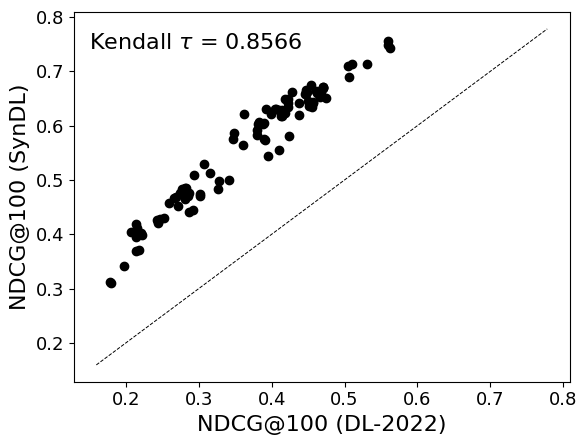

In [419]:
get_plot_simple(runid_to_score_track_nist, runid_to_score_track_gpt4, query_types=[f'DL-{year}', 'SynDL'], label_types=['Human', 'GPT-4'])

In [420]:
# get_plot(runid_to_score_track_nist, runid_to_score_track_gpt4, query_types=[f'DL-{year}', 'SynDL'], label_types=['Human', 'GPT-4'])